# Team 88: Project Dataset Details
## Airport Traffic Data

In [2]:
#modules
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

### [Airport and Airline Data](https://www.transtats.bts.gov/tables.asp?db_id=125&DB_Name=Airline%20Origin%20and%20Destination%20Survey%20(DB1B))
The Bureau of Transportation Statistics provides data on a 10% sample of flights and airline tickets going back to 1993 and recorded quarterly. The data can be filtered by destination airport and date. Bay Area destination airports of interest to us are San Francisco International Airport and Oakland International Airport. 

### Data Acquisition
With this data, the extraction process is a bit more manually involved as we need to download the files for each year and each quarter separately before combining them and making sure all the variables track before starting the analysis and exploration. There are two tables we need to explore in order to get all our variables of interest. These are `DB1BMarket` and `DB1BTicket`, and can be found [here](https://www.transtats.bts.gov/tables.asp?db_id=125&DB_Name=Airline%20Origin%20and%20Destination%20Survey%20%28DB1B%29). Part of our decision making will also include deciding how many years to explore - especially as we hope to be looking at the effects of wildfires on mobility and travel in the last decade. As this is only 10% of the actual traffic, we are hoping the sample is representative enough of trends.

Some relevant variables for us include for each of the tables includes:

***DB1BMarket***
- ItinID (int): a unique itinerary identifier which will help us connect the two tables together
- Orig and Dest (string): three letter airport codes for the origin/destination airport
- OriginAirportID(int) and DestAirportID (int): a unique identifier for the origin/destination airport
- Year and Quarter (string and int)
- Passengers (int): number of passengers

***DB1BTicket***
- ItinID (int): a unique itinerary identifier which will help us connect the two tables together
- RoundTrip (int): a round trip indicator (1=Yes, 0=No)
- ItinFare and FarePerMile (float): fares for the entire itinerary and per mile flown, respectively

### Dataset Structure and Features
To see more of the dataset, we are using a sample of the downloads for `2019 - Q3` for both `DB1BMarket` and `DB1BTicket` to see what variables look like and how we would think of using them for the purposes of this project.

In [3]:
df_market = pd.read_csv('data/920348143_T_DB1B_MARKET.csv')
df_ticket = pd.read_csv('data/920348143_T_DB1B_TICKET.csv')

In [4]:
#size of the data
for table, name in zip([df_market.shape, df_ticket.shape], ['market', 'ticket']):
    print('The airport', name, 'data has {} rows and {} columns'.format(table[0], table[1]))

The airport market data has 7141323 rows and 7 columns
The airport ticket data has 4390179 rows and 7 columns


In [5]:
#market view
df_market.head(2)

,ITIN_ID,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,PASSENGERS,Unnamed: 6
0,2019310,10135,ABE,10397,ATL,1.0,NaN
1,2019311,10135,ABE,10397,ATL,1.0,NaN


In [6]:
df_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7141323 entries, 0 to 7141322
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ITIN_ID            int64  
 1   ORIGIN_AIRPORT_ID  int64  
 2   ORIGIN             object 
 3   DEST_AIRPORT_ID    int64  
 4   DEST               object 
 5   PASSENGERS         float64
 6   Unnamed: 6         float64
dtypes: float64(2), int64(3), object(2)
memory usage: 381.4+ MB


In [7]:
#ticket view
df_ticket.head(2)

,ITIN_ID,YEAR,QUARTER,ROUNDTRIP,ITIN_YIELD,ITIN_FARE,Unnamed: 6
0,2019310,2019,3,0.0,0.0000,0.0,NaN
1,2019311,2019,3,0.0,0.0072,5.0,NaN


In [8]:
df_ticket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4390179 entries, 0 to 4390178
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ITIN_ID     int64  
 1   YEAR        int64  
 2   QUARTER     int64  
 3   ROUNDTRIP   float64
 4   ITIN_YIELD  float64
 5   ITIN_FARE   float64
 6   Unnamed: 6  float64
dtypes: float64(4), int64(3)
memory usage: 234.5 MB


For each table, we have picked up an empty column that has no meaning so we can drop it for both to save computational time while processing the dataframes.

In [11]:
df_market = df_market.drop(['Unnamed: 6'], axis=1)
df_ticket = df_ticket.drop(['Unnamed: 6'], axis=1)

In [10]:
#checking if itinerary ID is unique
df_market['ITIN_ID'].value_counts()

201935934420    10
201931763496    10
201933115014     8
201938036        8
201933154796     8
                ..
20193852642      1
201932991688     1
201932995786     1
20193762526      1
201934813207     1
Name: ITIN_ID, Length: 4390179, dtype: int64

From the above market table data, we see that the count of unique values is the same as the total rows in the ticket table data. This confirms that the `INIT_ID` field is one we can use to merge the two tables. We can now do that and explore airport markets and traffic in the Bay Area airports

In [14]:
df_travel = pd.merge(df_market, df_ticket, on='ITIN_ID')
df_travel.head(2)

,ITIN_ID,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,PASSENGERS,YEAR,QUARTER,ROUNDTRIP,ITIN_YIELD,ITIN_FARE
0,2019310,10135,ABE,10397,ATL,1.0,2019,3,0.0,0.0000,0.0
1,2019311,10135,ABE,10397,ATL,1.0,2019,3,0.0,0.0072,5.0


### Bay Area Airports
According to [this article](https://traveltips.usatoday.com/airports-bay-area-california-104230.html) and two other quick searches, there are four main passenger airports in the California Bay Area. These are:
- San Francisco International Airport (SFO) — Class B airspace
- Norman Y. Mineta San José International Airport (SJC) — Class C airspace
- Oakland International Airport (OAK) — Class C airspace
- Charles M. Schulz–Sonoma County Airport (STS) — Class D airspace

These will be the ones we focus on for analyses for the combined dataset.


In [20]:
bay_area_destinations = ['SFO', 'SJC', 'OAK', 'STS']
df_bayarea = df_travel[df_travel['DEST'].isin(bay_area_destinations)]

#dataframe metrics for quarter
print('In Q3 2019, 10% of airport traffic data shows {} inbound bay area flight itineraries'.format(df_bayarea.shape[0]))

In Q3 2019, 10% of airport traffic data shows 281793 inbound bay area flights


In [21]:
df_bayarea.describe()

,ITIN_ID,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,PASSENGERS,YEAR,QUARTER,ROUNDTRIP,ITIN_YIELD,ITIN_FARE
count,2.817930e+05,281793.000000,281793.000000,281793.000000,281793.0,281793.0,281793.000000,281793.000000,281793.000000
mean,1.892004e+11,12717.755672,14641.191172,2.596999,2019.0,3.0,0.719954,0.208882,467.047120
std,4.655266e+10,1518.700830,360.349496,8.754858,0.0,0.0,0.449022,0.221937,400.044297
min,2.019333e+07,10135.000000,13796.000000,1.000000,2019.0,3.0,0.000000,0.000000,0.000000
25%,2.019317e+11,11292.000000,14771.000000,1.000000,2019.0,3.0,0.000000,0.098300,239.000000
50%,2.019339e+11,12889.000000,14771.000000,1.000000,2019.0,3.0,1.000000,0.150800,394.000000
75%,2.019348e+11,14057.000000,14831.000000,2.000000,2019.0,3.0,1.000000,0.261200,585.000000
max,2.019359e+11,16218.000000,15023.000000,621.000000,2019.0,3.0,1.000000,31.112800,15360.000000


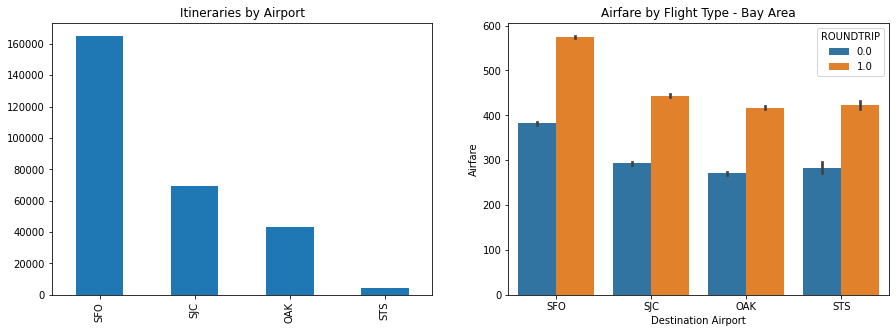

In [27]:
#flights inbound by airport
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
df_bayarea['DEST'].value_counts().plot.bar(ax=ax1, title='Itineraries by Airport')
sns.barplot(x='DEST', y='ITIN_FARE', hue='ROUNDTRIP',data=df_bayarea, ax=ax2)
ax2.set(xlabel='Destination Airport', ylabel='Airfare', title='Airfare by Flight Type - Bay Area')
plt.show()

We see that San Francisco International Airport has the most traffic which makes sense as it is a major hub. There is also the expected majority of return flights compared to one-way travel to the bay area. This tells us a lot of the people are visiting this area. It would be nice to know how long they stay, but for the purposes of this exploration and even phase 1 of our project, we will not delve that deep on that aspect. There is an outlier for over $15,000 in airfare for an itinerary that seems to cover the corresponding passenger count outlier of over 600 people.

### Other Features:
More variables that might be interesting to explore more during EDA include passengers - to see if the volume matches up with the airports to scale. Additionally, we can compare the airfares across quarters once all the data is concatenated to include all years of interest. Another thing we can look into once we decide the duration scope is how the price changes throughout the year affect travel. For instance, we would expect the Indigenous people's weekend travel to be a busy time for all airports along with Christmas season. Those impacts would be useful to consider so that it is noted and not compounded when looking at wildfire season and patterns of travel during those times.

### Supplemental Information
We can use other data from a quick search to see if there are other airports and cities we should be looking at in the Bay Area. Additionally, we can get a list of all cities associated here and find the corresponding county and use that to connect with other datasets e.g. air quality data and fire incident data. This would help us attach other datasets to this one. For linking data we anticipate two variables:
- Time (quarter and year)
- Location (city, county, and state)
- *Potentially* counties for airports